In [1]:
!pip install lightgbm

You should consider upgrading via the '/Users/sundara/Documents/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


In [3]:
import os

In [4]:
from datetime import datetime

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_log_error

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer

In [7]:
from sklearn.model_selection import TimeSeriesSplit

In [8]:
from lightgbm import LGBMRegressor

In [9]:
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [10]:
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [11]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
#     ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
#            xlabel='Sample index', ylabel="CV iteration",
#            ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    

In [12]:
class StoreCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_features = [], feature_name = "StoreCat"):
        print("\n>>>>>>>>>>init() called.\n")
        self.feature_name = feature_name
        self.input_features = input_features
        
    def fit(self, X, y=None):
        print("\n>>>>>>>>>>fit() called.\n")
        return self
    
    def transform(self, X, y = None):
        print("\n>>>>>>>>>>transform() called.\n")
        X_ = X.copy()
        X_[self.feature_name] = ''
        for col in self.input_features:
            X_[self.feature_name] = X_[self.feature_name] + X_[col]
        le = LabelEncoder()
        X_[self.feature_name] = le.fit_transform(X_[self.feature_name])
        return X_

In [13]:
class DayOfWeekTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("\n>>>>>>>>>>init() called.\n")
        self.dayOfWeekDict = {0:"Monday",
                 1:"Tuesday",
                 2:"Wednesday",
                 3:"Thursday",
                 4:"Friday",
                 5:"Saturday",
                 6:"Sunday"}
        
    def fit(self, X, y=None):
        print("\n>>>>>>>>>>fit() called.\n")
        return self
    
    def transform(self, X, y = None):
        print("\n>>>>>>>>>>transform() called.\n")
        X_ = X.copy()
        X_['Date'] = pd.to_datetime(X_['Date'])
        X_['Year'] = X_['Date'].dt.year
        X_['Month'] = X_['Date'].dt.month
        X_['DayOfWeek'] = X_['Date'].dt.dayofweek
        X_['DayOfWeek'] = X_['DayOfWeek'].apply(lambda x : self.dayOfWeekDict.get(x))
        le = LabelEncoder()
        X_["DayOfWeek"] = le.fit_transform(X_["DayOfWeek"])
        return X_

In [14]:
class CustomLabelEncode(BaseEstimator, TransformerMixin):
    def __init__(self, feature):
        self.feature = feature
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.feature] = LabelEncoder().fit_transform(X_[self.feature])
        return X_

In [15]:
filename = "TRAIN.csv"
testfilename = "TEST_FINAL.csv"

In [16]:
homedir = os.path.abspath(os.path.dirname("__name__"))

In [17]:
fp = os.path.join(homedir, filename)
testfp = os.path.join(homedir, testfilename)

In [18]:
mms = MinMaxScaler()

In [19]:
df = pd.read_csv(fp)


In [20]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        
        ("DiscountEncoder", CustomLabelEncode("Discount"))
    ], remainder='passthrough'
)

In [22]:
mycols = ['Store_id', "Date", "Holiday", "Discount", "StoreCat", "DayOfWeek"]

In [23]:
pipe = Pipeline(steps = [
    ("preprocess",CustomLabelEncode("Discount")),
    ("transform1", StoreCatTransformer(["Store_Type", "Location_Type", "Region_Code"], "StoreCat")),
    ("transform2", DayOfWeekTransformer()),
#     ("selector", ColumnTransformer([
#         ("selector", "passthrough", mycols)
#     ], remainder="drop")),
    
])


>>>>>>>>>>init() called.


>>>>>>>>>>init() called.



In [24]:
df2 = pipe.fit_transform(df)


>>>>>>>>>>fit() called.


>>>>>>>>>>transform() called.


>>>>>>>>>>fit() called.


>>>>>>>>>>transform() called.



In [25]:
df2.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,8,2018,1,1
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,46,2018,1,1
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,36,2018,1,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,21,2018,1,1
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,24,2018,1,1


In [26]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [27]:
df2.dtypes

ID                       object
Store_id                  int64
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                   int64
Discount                  int64
#Order                    int64
Sales                   float64
StoreCat                  int64
Year                      int64
Month                     int64
DayOfWeek                 int64
dtype: object

In [28]:
df2.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'StoreCat', 'Year', 'Month',
       'DayOfWeek'],
      dtype='object')

In [29]:
df2.set_index("Date", inplace=True)

In [30]:
df2.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek
Date,,,,,,,,,,,,,
2018-01-01,T1000001,1,S1,L3,R1,1,1,9,7011.84,8,2018,1,1
2018-01-01,T1000002,253,S4,L2,R1,1,1,60,51789.12,46,2018,1,1
2018-01-01,T1000003,252,S3,L2,R1,1,1,42,36868.20,36,2018,1,1
2018-01-01,T1000004,251,S2,L3,R1,1,1,23,19715.16,21,2018,1,1
2018-01-01,T1000005,250,S2,L3,R4,1,1,62,45614.52,24,2018,1,1


In [31]:
traindf = df2.loc["2018-01-01":"2018-12-31"]
testdf = df2.loc["2018-10-01":"2019-05-31"]


# traindf =storedf[:trainlen] 
# testdf = storedf[trainlen:] 

In [32]:
traindf.reset_index(inplace=True)

In [33]:
traindf.shape

(133225, 14)

In [34]:
traindf["7SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=7).mean().reset_index(0,drop=True)
traindf["7EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=7).mean().reset_index(0,drop=True)

traindf["14SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=14).mean().reset_index(0,drop=True)
traindf["14EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=14).mean().reset_index(0,drop=True)

traindf["30SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=30).mean().reset_index(0,drop=True)
traindf["30EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=30).mean().reset_index(0,drop=True)

traindf["60SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=60).mean().reset_index(0,drop=True)
traindf["60EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=60).mean().reset_index(0,drop=True)

traindf["90SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=90).mean().reset_index(0,drop=True)
traindf["90EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=90).mean().reset_index(0,drop=True)

<ipython-input-34-e1c9864490eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf["7SMA"] = traindf.groupby("Store_id")['Sales'].rolling(window=7).mean().reset_index(0,drop=True)
<ipython-input-34-e1c9864490eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf["7EMA"] = traindf.groupby("Store_id")['Sales'].ewm(span=7).mean().reset_index(0,drop=True)
<ipython-input-34-e1c9864490eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [35]:
traindf.dropna(inplace=True)

<ipython-input-35-739e0a91c5df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf.dropna(inplace=True)


In [36]:
traindf.head()

,Date,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,7SMA,7EMA,14SMA,14EMA,30SMA,30EMA,60SMA,60EMA,90SMA,90EMA
32485,2018-03-31,T1032486,136,S2,L5,R4,0,1,38,28149.0,31,2018,3,2,21618.385714,22686.470619,23070.407143,23092.869734,24161.530,23991.592353,24405.8155,24525.224923,25326.645667,24742.811787
32486,2018-03-31,T1032487,179,S1,L1,R2,0,1,59,37686.0,1,2018,3,2,39073.238571,38449.953610,40710.833571,40774.560015,44238.441,43235.105797,44791.3740,44671.212480,46677.219333,45247.101605
32487,2018-03-31,T1032488,336,S4,L2,R1,0,1,165,93981.0,46,2018,3,2,63538.195714,68215.501466,66840.169286,67215.032256,68697.601,68134.416757,67742.7275,68378.181541,68097.657333,68332.810839
32488,2018-03-31,T1032489,22,S1,L1,R4,0,1,61,47733.0,3,2018,3,2,39253.247143,40450.828317,41918.552143,41605.791488,43704.403,43345.310973,44184.6125,44491.832803,46423.637000,45011.900534
32489,2018-03-31,T1032490,212,S4,L2,R3,0,1,113,65406.0,48,2018,3,2,55587.557143,55866.692792,56172.707143,56923.196916,59122.655,58655.178790,59305.3070,59721.410805,61495.592000,60188.931262


In [37]:
yval = mms.fit_transform(np.array(traindf['Sales']).reshape(-1,1))

In [38]:
model_lgbm = LGBMRegressor(max_depth=5)

In [39]:
X = traindf.loc[:, ('Store_id', 'DayOfWeek', 'StoreCat', 'Discount', 'Holiday', 
                    "7SMA","7EMA", "14SMA", "14EMA","30SMA", "60SMA", "90SMA", "30EMA", "60EMA", "90EMA")]

In [41]:
model_lgbm.fit(X, yval)

/Users/sundara/Documents/venv/lib/python3.9/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(max_depth=5)

In [42]:
importance = model_lgbm.feature_importances_

In [43]:
X.columns.tolist()

['Store_id',
 'DayOfWeek',
 'StoreCat',
 'Discount',
 'Holiday',
 '7SMA',
 '7EMA',
 '14SMA',
 '14EMA',
 '30SMA',
 '60SMA',
 '90SMA',
 '30EMA',
 '60EMA',
 '90EMA']

Feature: 0, Score: 49.00000
Feature: 1, Score: 343.00000
Feature: 2, Score: 88.00000
Feature: 3, Score: 227.00000
Feature: 4, Score: 287.00000
Feature: 5, Score: 490.00000
Feature: 6, Score: 798.00000
Feature: 7, Score: 288.00000
Feature: 8, Score: 93.00000
Feature: 9, Score: 92.00000
Feature: 10, Score: 26.00000
Feature: 11, Score: 46.00000
Feature: 12, Score: 48.00000
Feature: 13, Score: 8.00000
Feature: 14, Score: 37.00000


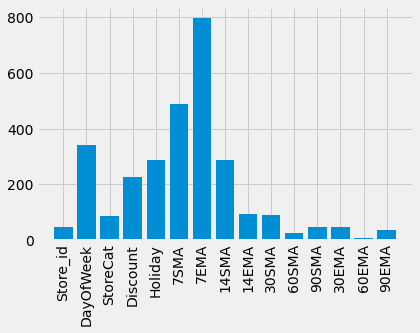

In [44]:
collist = X.columns.tolist()

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([collist[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

In [45]:
testdf['zSales'] = testdf['Sales']


<ipython-input-45-fa1b1040081f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['zSales'] = testdf['Sales']


In [46]:
testdf.loc["2019-01-01":"2019-05-31", "zSales"] = 0

/Users/sundara/Documents/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [47]:
testdf.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,zSales
Date,,,,,,,,,,,,,,
2018-10-01,T1099646,85,S4,L2,R1,0,1,145,77082.0,46,2018,10,1,77082.0
2018-10-01,T1099647,86,S1,L1,R4,0,0,50,30138.0,3,2018,10,1,30138.0
2018-10-01,T1099648,14,S3,L2,R4,0,1,75,54834.0,39,2018,10,1,54834.0
2018-10-01,T1099649,131,S4,L2,R1,0,1,130,70011.0,46,2018,10,1,70011.0
2018-10-01,T1099650,102,S4,L2,R1,0,1,101,62481.0,46,2018,10,1,62481.0


In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [49]:
pd.options.mode.chained_assignment = None 

In [50]:
predlist = []
for sid in testdf['Store_id'].unique().tolist():
    sdf = testdf[testdf['Store_id']==sid]
    for ix in [x for x in sdf.index.strftime("%Y-%m-%d").tolist() if x > "2018-12-31"]:
        tempdf = sdf.loc[:ix]
        tempdf = tempdf[-90:]
        
        tempdf["7SMA"] = tempdf.groupby("Store_id")['Sales'].rolling(window=7).mean().reset_index(0,drop=True)
        tempdf["7EMA"] = tempdf.groupby("Store_id")['Sales'].ewm(span=7).mean().reset_index(0,drop=True)

        tempdf["14SMA"] = tempdf.groupby("Store_id")['Sales'].rolling(window=14).mean().reset_index(0,drop=True)
        tempdf["14EMA"] = tempdf.groupby("Store_id")['Sales'].ewm(span=14).mean().reset_index(0,drop=True)
        
        tempdf["60SMA"] = tempdf.rolling(window=60)['zSales'].mean()
        tempdf["60EMA"] = tempdf.ewm(span=60)['zSales'].mean()

        tempdf["30SMA"] = tempdf.rolling(window=30)['zSales'].mean()
        tempdf["30EMA"] = tempdf.ewm(span=30)['zSales'].mean()

        tempdf["90SMA"] = tempdf.rolling(window=90)['zSales'].mean()
        tempdf["90EMA"] = tempdf.ewm(span=90)['zSales'].mean()
        tempdf.dropna(inplace=True)
#         print(ix)
#         print(tempdf.shape)
#         print(tempdf)
        texog = tempdf.loc[:, ('Store_id', 'DayOfWeek', 'StoreCat', 'Discount', 'Holiday',
                                      "7SMA","7EMA", "14SMA", "14EMA","30SMA", "60SMA", "90SMA", "30EMA", 
                                               "60EMA", "90EMA")]
#         print(texog.dtypes)
        pred = model_lgbm.predict(texog)
        predlist.append({"ID":tempdf.iloc[0, 0],"Date":ix, "Pred":pred.tolist()[0]})
        sdf.loc[ix, "zSales"] = pred.tolist()[0]
        
#         print(tempdf.tail(1))
    

In [51]:
len(predlist)

55115

In [52]:
outdf = pd.DataFrame(predlist).set_index("Date")

In [53]:
outdf.head()

,ID,Pred
Date,,
2019-01-01,T1133413,0.169221
2019-01-02,T1133705,0.258395
2019-01-03,T1134186,0.259528
2019-01-04,T1134569,0.312483
2019-01-05,T1134797,0.464997


In [54]:
outdf['zPred'] = mms.inverse_transform(np.array(outdf['Pred']).reshape(-1,1))

In [55]:
testdf2 = pd.merge(testdf, outdf[["ID", "zPred"]], on="ID", how='left')

In [56]:
testdf2.dropna(inplace=True)

In [57]:
testdf2['Pred'] = testdf2['zPred'].apply(lambda x : 0 if x<0 else x)

In [58]:
testdf2.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,zSales,zPred,Pred
33580,T1133226,304,S1,L1,R4,1,0,57,45634.50,3,2019,1,5,0.0,40028.806900,40028.806900
33581,T1133227,162,S4,L1,R2,1,0,63,41877.45,43,2019,1,5,0.0,31704.834937,31704.834937
33582,T1133228,148,S1,L1,R2,1,0,30,23139.00,1,2019,1,5,0.0,21593.417708,21593.417708
33583,T1133229,94,S4,L2,R2,1,1,60,43645.20,47,2019,1,5,0.0,46011.033293,46011.033293
33584,T1133230,137,S4,L1,R1,1,0,64,40367.70,42,2019,1,5,0.0,32485.371892,32485.371892


In [59]:
negativedf = testdf2[testdf2['Pred'] <0]

In [60]:
testdf2.dropna(inplace=True)

In [61]:
mean_squared_log_error(testdf2['Sales'], testdf2['Pred'])*1000

49.59803624567281

# Test 

In [62]:
combdf = testdf.loc['2019-03-01':'2019-05-31']

In [63]:
combdf[combdf['Store_id']==1].shape

(92, 14)

In [64]:
combdf

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,zSales
Date,,,,,,,,,,,,,,
2019-03-01,T1154761,121,S1,L1,R4,1,1,56,39025.98,3,2019,3,0,0.0
2019-03-01,T1154762,176,S4,L2,R3,1,1,112,69877.83,48,2019,3,0,0.0
2019-03-01,T1154763,3,S4,L2,R1,1,1,88,42984.00,46,2019,3,0,0.0
2019-03-01,T1154764,195,S4,L1,R1,1,1,106,59296.86,42,2019,3,0,0.0
2019-03-01,T1154765,255,S3,L2,R4,1,1,78,53622.66,39,2019,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,T1188336,149,S2,L3,R2,1,1,51,37272.00,22,2019,5,0,0.0
2019-05-31,T1188337,153,S4,L2,R1,1,0,90,54572.64,46,2019,5,0,0.0
2019-05-31,T1188338,154,S1,L3,R2,1,0,56,31624.56,9,2019,5,0,0.0


In [65]:
combdf.shape

(33580, 14)

In [66]:
validdf = pd.read_csv(testfp)

In [67]:
validdf2 = pipe.fit_transform(validdf)


>>>>>>>>>>fit() called.


>>>>>>>>>>transform() called.


>>>>>>>>>>fit() called.


>>>>>>>>>>transform() called.



In [68]:
validdf2['Date'] = pd.to_datetime(validdf2['Date'])

In [69]:
validdf2.set_index("Date", inplace=True)

In [70]:
validdf2.shape

(22265, 11)

In [71]:
validdf2.shape[0] + combdf.shape[0]

55845

In [72]:
mixdf = pd.concat([combdf, validdf2])

In [73]:
mixdf.shape[0]

55845

In [74]:
mixdf['zSales'] = mixdf['Sales']

In [75]:
mixdf.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,zSales
Date,,,,,,,,,,,,,,
2019-03-01,T1154761,121,S1,L1,R4,1,1,56.0,39025.98,3,2019,3,0,39025.98
2019-03-01,T1154762,176,S4,L2,R3,1,1,112.0,69877.83,48,2019,3,0,69877.83
2019-03-01,T1154763,3,S4,L2,R1,1,1,88.0,42984.00,46,2019,3,0,42984.00
2019-03-01,T1154764,195,S4,L1,R1,1,1,106.0,59296.86,42,2019,3,0,59296.86
2019-03-01,T1154765,255,S3,L2,R4,1,1,78.0,53622.66,39,2019,3,0,53622.66


In [76]:
mixdf['zSales'].fillna(0, inplace=True)

In [77]:
mixdf['#Order'].fillna(0, inplace=True)

In [78]:
mixdf.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,StoreCat,Year,Month,DayOfWeek,zSales
Date,,,,,,,,,,,,,,
2019-07-31,T1210601,186,S2,L5,R2,0,0,0.0,NaN,29,2019,7,6,0.0
2019-07-31,T1210602,11,S4,L2,R1,0,0,0.0,NaN,46,2019,7,6,0.0
2019-07-31,T1210603,185,S1,L1,R3,0,1,0.0,NaN,2,2019,7,6,0.0
2019-07-31,T1210604,69,S1,L1,R4,0,0,0.0,NaN,3,2019,7,6,0.0
2019-07-31,T1210605,365,S2,L1,R2,0,0,0.0,NaN,18,2019,7,6,0.0


In [79]:
validdf2.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,StoreCat,Year,Month,DayOfWeek
Date,,,,,,,,,,,
2019-06-01,T1188341,171,S4,L2,R3,0,0,48,2019,6,2
2019-06-01,T1188342,172,S1,L1,R1,0,0,0,2019,6,2
2019-06-01,T1188343,173,S4,L2,R1,0,0,46,2019,6,2
2019-06-01,T1188344,174,S1,L1,R4,0,0,3,2019,6,2
2019-06-01,T1188345,170,S1,L1,R2,0,0,1,2019,6,2


In [80]:
predlist = []
for sid in mixdf['Store_id'].unique().tolist():
    sdf = mixdf[mixdf['Store_id']==sid]
    for ix in [x for x in sdf.index.strftime("%Y-%m-%d").tolist() if x > "2019-05-31"]:
        tempdf = sdf.loc[:ix]
        tempdf.drop("Sales", axis=1, inplace=True)
        tempdf = tempdf[-90:]
        
        tempdf["7SMA"] = tempdf.groupby("Store_id")['zSales'].rolling(window=7).mean().reset_index(0,drop=True)
        tempdf["7EMA"] = tempdf.groupby("Store_id")['zSales'].ewm(span=7).mean().reset_index(0,drop=True)

        tempdf["14SMA"] = tempdf.groupby("Store_id")['zSales'].rolling(window=14).mean().reset_index(0,drop=True)
        tempdf["14EMA"] = tempdf.groupby("Store_id")['zSales'].ewm(span=14).mean().reset_index(0,drop=True)
        
        tempdf["60SMA"] = tempdf.rolling(window=60)['zSales'].mean()
        tempdf["60EMA"] = tempdf.ewm(span=60)['zSales'].mean()

        tempdf["30SMA"] = tempdf.rolling(window=30)['zSales'].mean()
        tempdf["30EMA"] = tempdf.ewm(span=30)['zSales'].mean()

        tempdf["90SMA"] = tempdf.rolling(window=90)['zSales'].mean()
        tempdf["90EMA"] = tempdf.ewm(span=90)['zSales'].mean()
#         print(tempdf.head())
#         print(tempdf.tail())
        tempdf.dropna(inplace=True)
#         print(ix)
#         print(tempdf.shape)
#         print(tempdf)
        texog = tempdf.loc[:, ('Store_id', 'DayOfWeek', 'StoreCat', 'Discount', 'Holiday',
                                      "7SMA","7EMA", "14SMA", "14EMA",
                               "30SMA", "60SMA", "90SMA", "30EMA", "60EMA", "90EMA")]
#         print(texog.dtypes)
        pred = model_lgbm.predict(texog)
        predlist.append({"ID":tempdf.iloc[0, 0],"Date":ix, "Pred":pred.tolist()[0]})
        sdf.loc[ix, "zSales"] = pred.tolist()[0]
        
#         print(tempdf.tail(1))


In [81]:
outdf = pd.DataFrame(predlist).set_index("Date")

In [82]:
outdf['zPred'] = mms.inverse_transform(np.array(outdf['Pred']).reshape(-1,1))

In [83]:
validmixdf = pd.merge(validdf, outdf[["ID", "zPred"]], on="ID", how='left')

In [84]:
validmixdf['Sales'] = validmixdf['zPred'].apply(lambda x : 0 if x<0 else x)

In [85]:
validmixdf[["ID", "Sales"]].to_csv("Submission_{}.csv".format(datetime.now().microsecond), index=None)